In [1]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Using TensorFlow backend.


In [2]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [3]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [4]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [5]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpv70waum0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c44ce0748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpv70waum0/model.ckpt.
INFO:tensorflow:loss = 2.3078117, step = 1
INFO:tensorflow:global_step/sec: 2.3904
INFO:tensorflow:loss = 0.10088459, step = 101 (41.836 sec)
INFO:tensorflow:global_step/sec: 2.43471
INFO:tensorflow:loss = 0.055165537, step = 201 (41.072 sec)
INFO:tensorflow:global_step/sec: 2.40428
INFO:tensorflow:loss = 0.11226711, step = 301 (41.593 sec)
INFO:tensorflow:global_step/sec: 2.32123
INFO:tensorflow:loss = 0.08561884, step = 401 (43.080 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpv70waum0/model.ckpt.
INFO:tensorflow:Loss for final step: 0.037181996.


In [7]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-10-15:27:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpv70waum0/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-10-15:28:05
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.9807, global_step = 500, loss = 0.060304478
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpv70waum0/model.ckpt-500


{'accuracy': 0.9807, 'loss': 0.060304478, 'global_step': 500}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpv70waum0/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


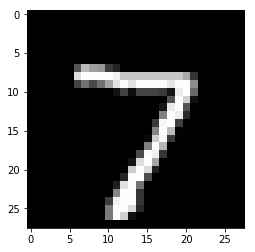

Model prediction: 7


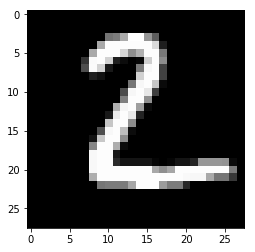

Model prediction: 2


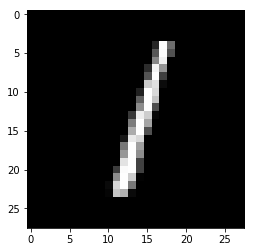

Model prediction: 1


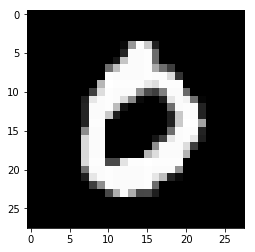

Model prediction: 0


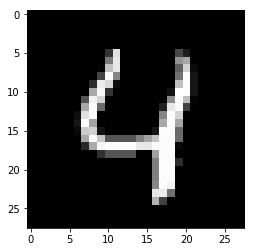

Model prediction: 4


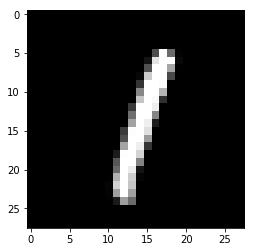

Model prediction: 1


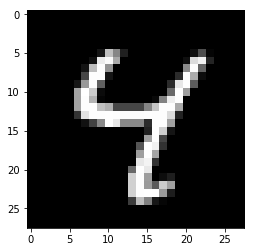

Model prediction: 4


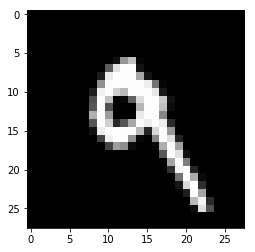

Model prediction: 9


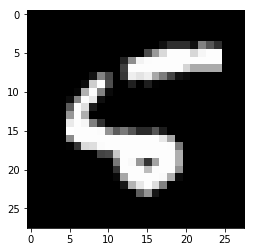

Model prediction: 5


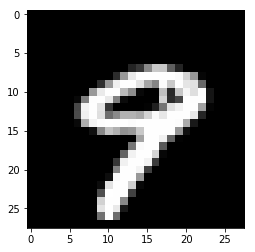

Model prediction: 9


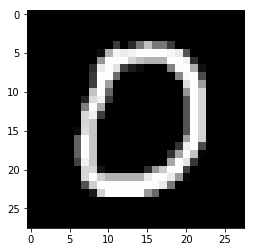

Model prediction: 0


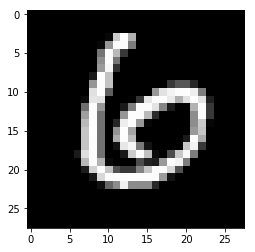

Model prediction: 6


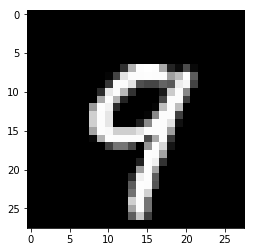

Model prediction: 9


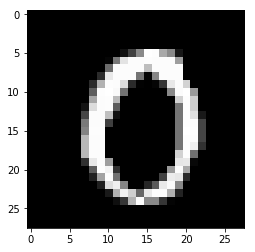

Model prediction: 0


In [57]:
# Predict single images
n_images = 14
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

[[[[-0.06705093 -0.06604195 -0.06944847 ... -0.06493378 -0.0645752
    -0.06321716]
   [-0.06451416 -0.06414795 -0.06489563 ... -0.06441879 -0.06435394
    -0.06430435]
   [-0.06424713 -0.0644722  -0.06420135 ... -0.0643692  -0.06428528
    -0.06440735]
   ...
   [-0.06441116 -0.06438446 -0.06443405 ... -0.06435394 -0.06437683
    -0.06438828]
   [-0.0643425  -0.06437683 -0.06439972 ... -0.0643692  -0.06439209
    -0.06437683]
   [-0.06437683 -0.06437683 -0.06438446 ... -0.06448746 -0.06409836
    -0.0644455 ]]]


 [[[-0.03505898 -0.03492737 -0.03902817 ... -0.03573608 -0.03445435
    -0.03412628]
   [-0.03551483 -0.03513336 -0.03618622 ... -0.03578186 -0.0357666
    -0.0357933 ]
   [-0.03557205 -0.03586197 -0.0356102  ... -0.03583527 -0.03557587
    -0.03588867]
   ...
   [-0.0358429  -0.03583527 -0.0358429  ... -0.03577805 -0.0357933
    -0.03581238]
   [-0.03575897 -0.03579712 -0.03580093 ... -0.03578186 -0.03580475
    -0.03579712]
   [-0.03578949 -0.03578949 -0.03580093 ... -0.035

/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:787: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpv70waum0/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


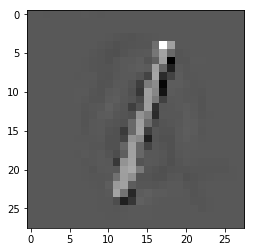

Model prediction: 1


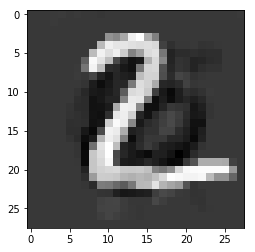

Model prediction: 2


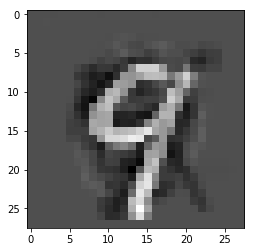

Model prediction: 9


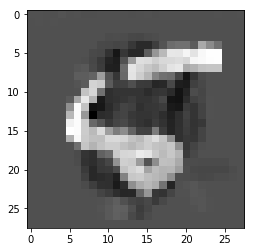

Model prediction: 6


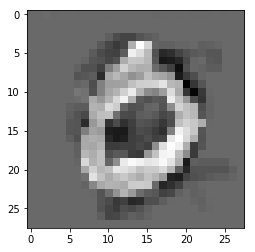

Model prediction: 0


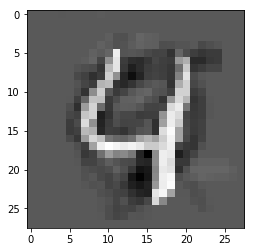

Model prediction: 4


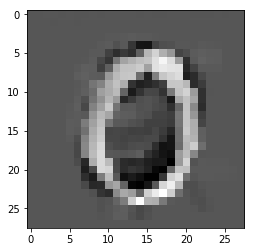

Model prediction: 0


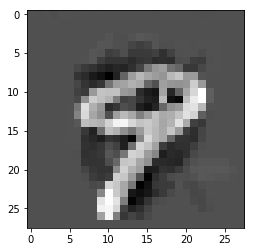

Model prediction: 9


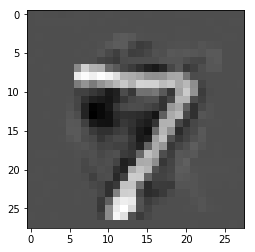

Model prediction: 7


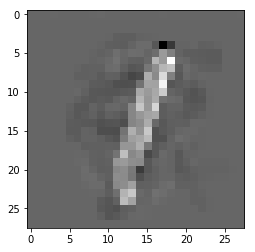

Model prediction: 1


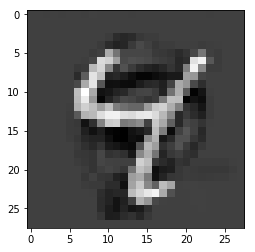

Model prediction: 4


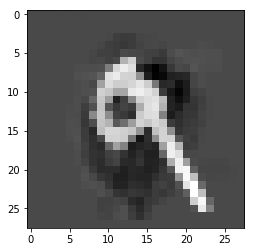

Model prediction: 9


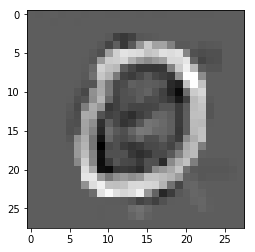

Model prediction: 2


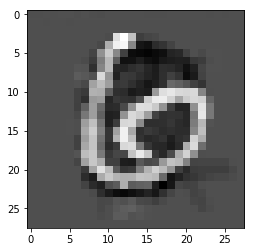

Model prediction: 6


In [56]:
# Predict single images
n_images = 14
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.train.labels[:n_images]
# Prepare the input data
(X_train, y_train), (X_test, y_test) = mn.load_data()
# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(X_test)
# configure batch size and retrieve one batch of images
tmp
for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=14):
    print(X_batch)
    tmp = X_batch
    # create a grid of 3x3 images
#     for i in range(0, 14):
#         pyplot.subplot(330 + 1 + i)
        #pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
#         tmp.append(X_batch[i])
        # show the plot
        #pyplot.show()
    break


x_te={'images': tmp}
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_te, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(tmp[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

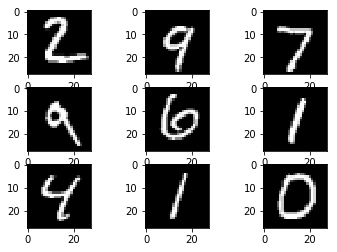

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmps9f4b0j0/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [45]:
# Predict single images
n_images = 14
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.train.labels[:n_images]
# Prepare the input data

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')
# define data preparation

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(X_test)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break
    
x_te={'images': test_images}
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_te, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# # Display
# for i in range(n_images):
#     plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
#     plt.show()
#     print("Model prediction:", preds[i])

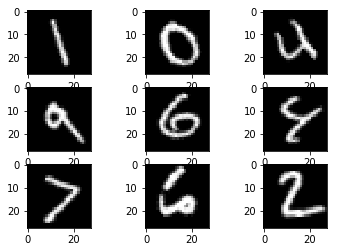

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmps9f4b0j0/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [50]:
# Predict single images
n_images = 14
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.train.labels[:n_images]
# Prepare the input data

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')
# define data preparation

datagen = ImageDataGenerator(rotation_range=45)
# fit parameters from data
datagen.fit(X_test)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break
    
x_te={'images': test_images}
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_te, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# # Display
# for i in range(n_images):
#     plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
#     plt.show()
#     print("Model prediction:", preds[i])

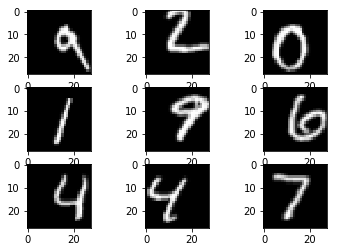

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmps9f4b0j0/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [51]:
# Predict single images
n_images = 14
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.train.labels[:n_images]
# Prepare the input data

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')
# define data preparation

shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)# fit parameters from data
datagen.fit(X_test)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break
    
x_te={'images': test_images}
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_te, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# # Display
# for i in range(n_images):
#     plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
#     plt.show()
#     print("Model prediction:", preds[i])